

```
# This is formatted as code
```

# PC LAB2 - Group 4 - Sofia Michael Yash Omar

Time spent: 8 hours
    Difficulty: 8/10

# Download Libraries and download the data

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import yfinance as yf
import requests
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [ ]:
df = pd.read_csv('Data_PCLab1_Stock.csv')

In [ ]:
# from google.colab import files
# uploaded = files.upload()   # Upload 'PCLab_Data.csv' file

# df = pd.read_csv('PCLab_Data.csv')

# Task #1 : Visualization and 1st step toward the CAPM

In [ ]:
#Compute daily returns
def compute_returns(df):
    """
    Compute daily returns for each column in the dataframe.
    """
    returns = df.pct_change().dropna()
    return returns

In [ ]:
# Convert the 'Date' column to datetime objects and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

returns = compute_returns(df)

In [ ]:
# Extract market returns
market_col = "sp500"
market_returns = returns[market_col]

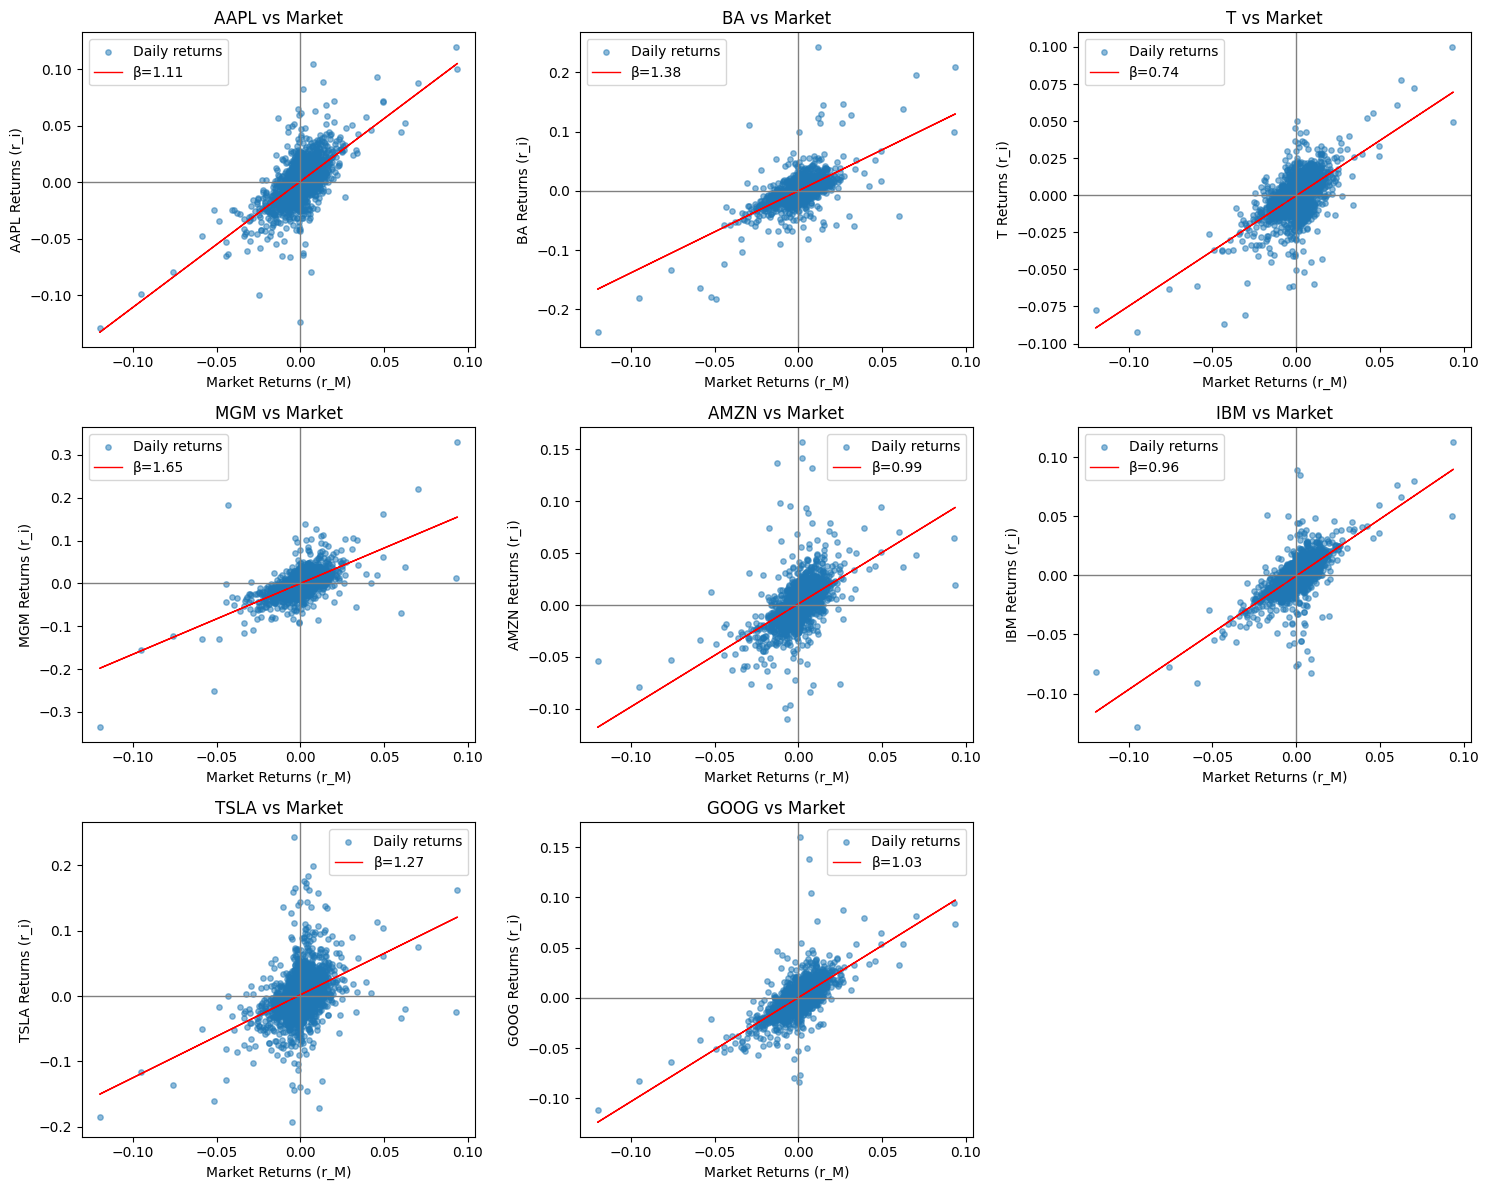

In [ ]:
# Scatter plot function
def plot_scatter_vs_market(ax, stock, returns, market_returns):
    """
    Scatter plot of stock vs market daily returns with regression line,
    drawn on a given matplotlib axis (ax).
    """
    x = market_returns.values
    y = returns[stock].values

    # Scatter
    ax.scatter(x, y, alpha=0.5, s=15, label="Daily returns")

    # Regression line (CAPM: r_i = alpha + beta r_M)
    beta, alpha = np.polyfit(x, y, 1)
    ax.plot(x, alpha + beta*x, color="red", linewidth=1, label=f"β={beta:.2f}")

    # Titles & labels
    ax.set_title(f"{stock} vs Market")
    ax.set_xlabel("Market Returns (r_M)")
    ax.set_ylabel(f"{stock} Returns (r_i)")
    ax.axhline(0, color='grey', linewidth=1)
    ax.axvline(0, color='grey', linewidth=1)
    ax.legend()


# 4. Create grid of plots
stocks = [col for col in returns.columns if col != market_col]

n = len(stocks)
ncols = 3   # number of plots per row
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, stock in enumerate(stocks):
    plot_scatter_vs_market(axes[i], stock, returns, market_returns)

# Hide any empty subplots if grid is bigger than stock list
for ax in axes[len(stocks):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

From the scatter plots, we observe a clear **positive correlation** between each stock’s daily returns and the market (proxied by the S&P500). This is consistent with the CAPM framework, which predicts that stock returns co-move with the market portfolio.

- **Strongest correlations / highest betas**:  
  - MGM (β ≈ 1.65), BA (β ≈ 1.38), and TSLA (β ≈ 1.27) show steep slopes, meaning they are more sensitive to market fluctuations. These stocks have **higher systematic risk** and, according to CAPM, should earn higher expected returns.

- **Weaker correlations / lower betas**:  
  - AT&T (T, β ≈ 0.74) shows the weakest relationship with the market, while IBM (β ≈ 0.96) and AMZN (β ≈ 0.99) move closer to one-for-one with market returns. These stocks carry **lower systematic risk**, and CAPM predicts lower expected returns for them.

Overall, the results confirm the CAPM intuition: the **slope of the regression line (β)** measures systematic risk, and stocks with higher β should, in theory, offer higher expected returns along the Security Market Line (SML).

# Task #2 : Compute alpha and beta

### OLS regression

In [ ]:
def run_capm_regression(returns, market_col="SP500", show = True):
    """
    Run OLS regression of stock returns on market returns (CAPM, rf = 0).
    """
    results = {}
    market_returns = returns[market_col]

    for stock in returns.columns:
        if stock != market_col:
            # Prepare the regression variables: X contains a constant (for alpha)
            # and the market returns; y is the return series of the stock.
            X = sm.add_constant(market_returns)
            y = returns[stock]

            # Run the CAPM regression: estimate alpha (intercept) and beta (slope).
            # This shows how much of the stock’s return can be explained by
            # movements in the market.
            model = sm.OLS(y, X).fit()

            # Store the fitted model in the dictionary for later use.
            results[stock] = model

            # Print a regression summary with coefficients, significance tests,
            # and R-squared (fit quality).
            if show:
              print(f"\nCAPM regression for {stock}:")
              print(model.summary())

    return results

In [ ]:
# Run CAPM regressions
capm_results = run_capm_regression(returns, market_col="sp500")


CAPM regression for AAPL:
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     1640.
Date:                Fri, 26 Sep 2025   Prob (F-statistic):          3.52e-267
Time:                        18:02:45   Log-Likelihood:                 6247.1
No. Observations:                2158   AIC:                        -1.249e+04
Df Residuals:                    2156   BIC:                        -1.248e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005    

We estimated the CAPM regressions:

$$
r_i = \alpha_i + \beta_i r_M + \varepsilon_i
$$

using daily returns for each stock against the S&P500 (market).

**Results:**
- All **β coefficients are highly significant** (p < 0.001), confirming that market returns explain a substantial part of stock returns.  
- **α (intercept)** values are generally close to zero and not statistically significant, consistent with CAPM’s prediction that there should be no abnormal return once risk is adjusted.  
- **R² values** range from **15% (TSLA)** to about **50% (IBM)**. This means that CAPM explains part of the variation in stock returns, but a large portion remains idiosyncratic risk, highlighting the empirical limits of CAPM.

**Connection with Task 1:**
- In Task 1, we visually observed steeper slopes for **MGM, BA, and TSLA**. In Task 2, their estimated betas are indeed the highest (MGM β ≈ 1.65, BA β ≈ 1.38, TSLA β ≈ 1.27).  
- The flatter plots in Task 1 (e.g., **T and IBM**) correspond to lower betas in Task 2 (T β ≈ 0.74, IBM β ≈ 0.96).  
- Stocks like **AAPL, AMZN, and GOOG** appeared roughly aligned with the market in Task 1, and their betas are close to 1 in Task 2.  

**Interpretation:**  
The regression results show that high-β stocks such as MGM, BA, and TSLA carry higher systematic risk and, according to the CAPM, should yield higher expected returns. In contrast, low-β stocks like T and IBM are less sensitive to market fluctuations and are therefore expected to provide lower returns. These findings confirm the patterns already observed in Task 1: the slopes visible in the scatter plots visually anticipate the β coefficients estimated through regression. At the same time, the relatively modest R² values highlight that the CAPM does not capture all the drivers of stock returns, since a substantial part of the variation is due to idiosyncratic factors beyond market risk, as discussed in Lecture 2.



### Compute beta and alpha

In [ ]:
def summarize_capm_results(results):
    """
    Extract alpha, beta, R², and p-values from CAPM regression results.
    """
    summary = []
    for stock, model in results.items():
        alpha = model.params['const']
        beta = model.params[market_col]
        r2 = model.rsquared
        p_alpha = model.pvalues['const']
        p_beta = model.pvalues[market_col]
        summary.append([stock, alpha, beta, r2, p_alpha, p_beta])

    df = pd.DataFrame(summary, columns=["Stock", "Alpha", "Beta", "R²", "p(Alpha)", "p(Beta)"])
    return df

In [ ]:
summary_df = summarize_capm_results(capm_results)
display(summary_df)

,Stock,Alpha,Beta,R²,p(Alpha),p(Beta)
0,AAPL,0.000528,1.112891,0.432070,0.067202,3.521164e-267
1,BA,-0.000023,1.382867,0.411941,0.951096,7.299279e-251
2,T,-0.000286,0.744630,0.381261,0.182942,4.892378e-227
3,MGM,-0.000169,1.653568,0.398728,0.712986,1.874186e-240
4,AMZN,0.001023,0.991732,0.291125,0.003512,2.611172e-163
5,IBM,-0.000535,0.960416,0.495525,0.014747,1.185758e-322
6,TSLA,0.001759,1.268611,0.150482,0.009920,1.965135e-78
7,GOOG,0.000334,1.034881,0.468638,0.180655,2.345742e-298


In [ ]:
# Round for readability
summary_df_round = summary_df.round(4)

# Sort by Beta
betas_sorted = summary_df_round.sort_values("Beta", ascending=False)
display(betas_sorted.style.background_gradient(subset=["Beta"], cmap="Reds").set_caption("Stocks Sorted by Beta"))

# Sort by Alpha
alphas_sorted = summary_df_round.sort_values("Alpha", ascending=False)
display(alphas_sorted.style.background_gradient(subset=["Alpha"], cmap="Greens").set_caption("Stocks Sorted by Alpha"))

,Stock,Alpha,Beta,R²,p(Alpha),p(Beta)
3,MGM,-0.000200,1.653600,0.398700,0.713000,0.000000
1,BA,-0.000000,1.382900,0.411900,0.951100,0.000000
6,TSLA,0.001800,1.268600,0.150500,0.009900,0.000000
0,AAPL,0.000500,1.112900,0.432100,0.067200,0.000000
7,GOOG,0.000300,1.034900,0.468600,0.180700,0.000000
4,AMZN,0.001000,0.991700,0.291100,0.003500,0.000000
5,IBM,-0.000500,0.960400,0.495500,0.014700,0.000000
2,T,-0.000300,0.744600,0.381300,0.182900,0.000000


,Stock,Alpha,Beta,R²,p(Alpha),p(Beta)
6,TSLA,0.001800,1.268600,0.150500,0.009900,0.000000
4,AMZN,0.001000,0.991700,0.291100,0.003500,0.000000
0,AAPL,0.000500,1.112900,0.432100,0.067200,0.000000
7,GOOG,0.000300,1.034900,0.468600,0.180700,0.000000
1,BA,-0.000000,1.382900,0.411900,0.951100,0.000000
3,MGM,-0.000200,1.653600,0.398700,0.713000,0.000000
2,T,-0.000300,0.744600,0.381300,0.182900,0.000000
5,IBM,-0.000500,0.960400,0.495500,0.014700,0.000000


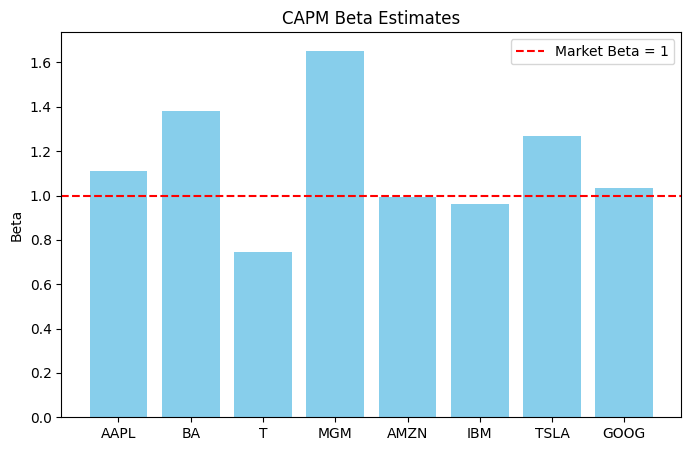

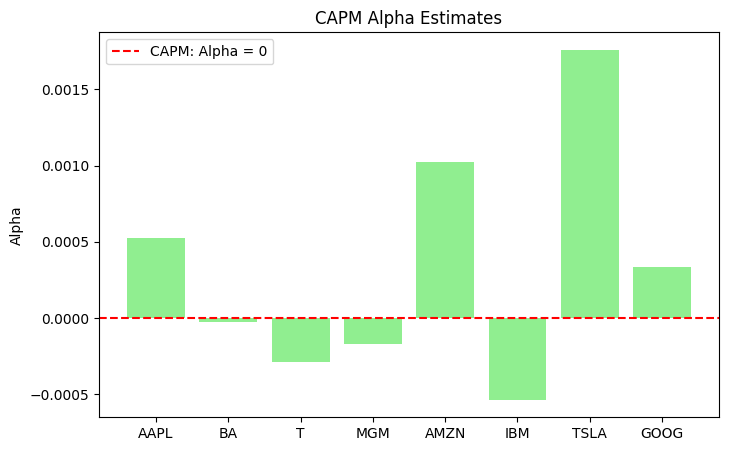

In [ ]:
#Visualiztion with BarPLots
# Plot Beta
plt.figure(figsize=(8,5))
plt.bar(summary_df["Stock"], summary_df["Beta"], color="skyblue")
plt.axhline(1, color="red", linestyle="--", label="Market Beta = 1")
plt.title("CAPM Beta Estimates")
plt.ylabel("Beta")
plt.legend()
plt.show()

# Plot Alpha
plt.figure(figsize=(8,5))
plt.bar(summary_df["Stock"], summary_df["Alpha"], color="lightgreen")
plt.axhline(0, color="red", linestyle="--", label="CAPM: Alpha = 0")
plt.title("CAPM Alpha Estimates")
plt.ylabel("Alpha")
plt.legend()
plt.show()

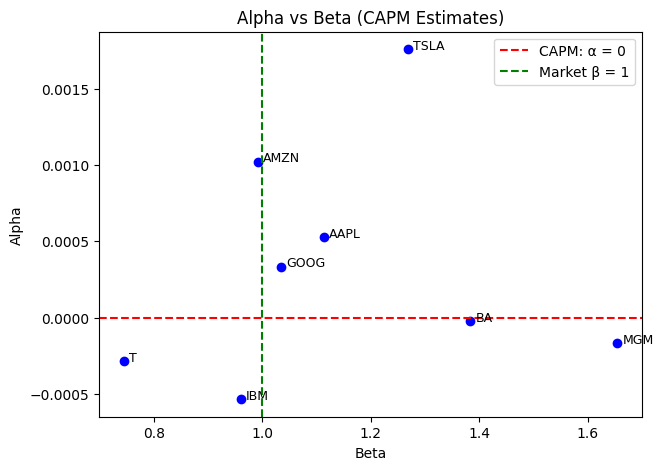

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(summary_df["Beta"], summary_df["Alpha"], color="blue")

for i, row in summary_df.iterrows():
    plt.text(row["Beta"]+0.01, row["Alpha"], row["Stock"], fontsize=9)

plt.axhline(0, color="red", linestyle="--", label="CAPM: α = 0")
plt.axvline(1, color="green", linestyle="--", label="Market β = 1")

plt.title("Alpha vs Beta (CAPM Estimates)")
plt.xlabel("Beta")
plt.ylabel("Alpha")
plt.legend()
plt.show()


In [ ]:
print(f"Number of Stocks with Beta > 1 : {summary_df[summary_df['Beta'] > 1].shape[0]}")

print(f"Number of Stocks with Beta < 1 : {summary_df[summary_df['Beta'] < 1].shape[0]}")

print(f"Number of Stocks with Beta = 1 : {summary_df[summary_df['Beta'] == 1].shape[0]}")

Number of Stocks with Beta > 1 : 5
Number of Stocks with Beta < 1 : 3
Number of Stocks with Beta = 1 : 0


In [ ]:
print(f"Average Beta : {summary_df['Beta'].mean()}")

Average Beta : 1.1436996832956308


To analyze the CAPM regression results, two types of plots were used: **bar plots** and a **scatter plot of alpha vs beta**.  

**Bar plots** were chosen because they allow for straightforward comparisons across stocks individually. By plotting betas and alphas separately, we can clearly identify which stock has the highest or lowest value. This directly answers the question *“which stock has the highest (lowest) beta and alpha?”* in a simple and intuitive way.
- **Betas (systematic risk):**  
  From the beta bar plot, MGM (β ≈ 1.65), BA (β ≈ 1.38), and TSLA (β ≈ 1.27) emerge as the riskiest stocks, with returns that amplify market movements. CAPM predicts that these stocks should yield higher expected returns. In contrast, T (β ≈ 0.74) and IBM (β ≈ 0.96) are more defensive, with returns that fluctuate less with the market, implying lower expected returns. AAPL, AMZN, and GOOG sit near β ≈ 1, moving broadly one-to-one with the market.  

- **Alphas (abnormal returns):**  
  The alpha bar plot shows that most alphas are very close to zero, consistent with CAPM’s prediction (α = 0 if markets are efficient). TSLA and AMZN display slightly positive alphas, which might suggest abnormal performance, but these values are economically small and not very significant. IBM and T exhibit slightly negative alphas, again of small magnitude. The key takeaway is that no stock consistently delivers abnormal returns once risk is accounted for.  

The **scatter plot (α vs β)** provides a joint view of both parameters in the CAPM framework. The vertical line at β = 1 represents the market risk, while the horizontal line at α = 0 reflects CAPM’s prediction of no abnormal returns. This visualization makes the theoretical structure of CAPM very clear: expected returns are determined by exposure to systematic risk (β), and alpha should be negligible. In other words, the scatter plot ties the regression results back to the **Security Market Line (SML)**.
- This combined view confirms the same insights. Stocks to the right of β = 1 (MGM, BA, TSLA) are riskier than the market, while those to the left (T, IBM) are less risky. The horizontal α = 0 line shows that all stocks lie close to it, reinforcing the idea that abnormal returns are negligible. This makes CAPM’s intuition very clear: **beta drives expected returns, while alpha remains close to zero.**

### Compute residuals

In [ ]:
def compute_residuals(results, returns, market_col="SP500"):
    """
    Compute residuals (ε) for each stock using CAPM regression results.
    """
    residuals = {}
    market_returns = returns[market_col]

    for stock, model in results.items():
        # Predicted returns = α + β * r_M
        alpha, beta = model.params
        predicted = alpha + beta * market_returns
        residuals[stock] = returns[stock] - predicted
    return pd.DataFrame(residuals)

In [ ]:
# Compute residuals
residuals_df = compute_residuals(capm_results, returns, market_col="sp500")

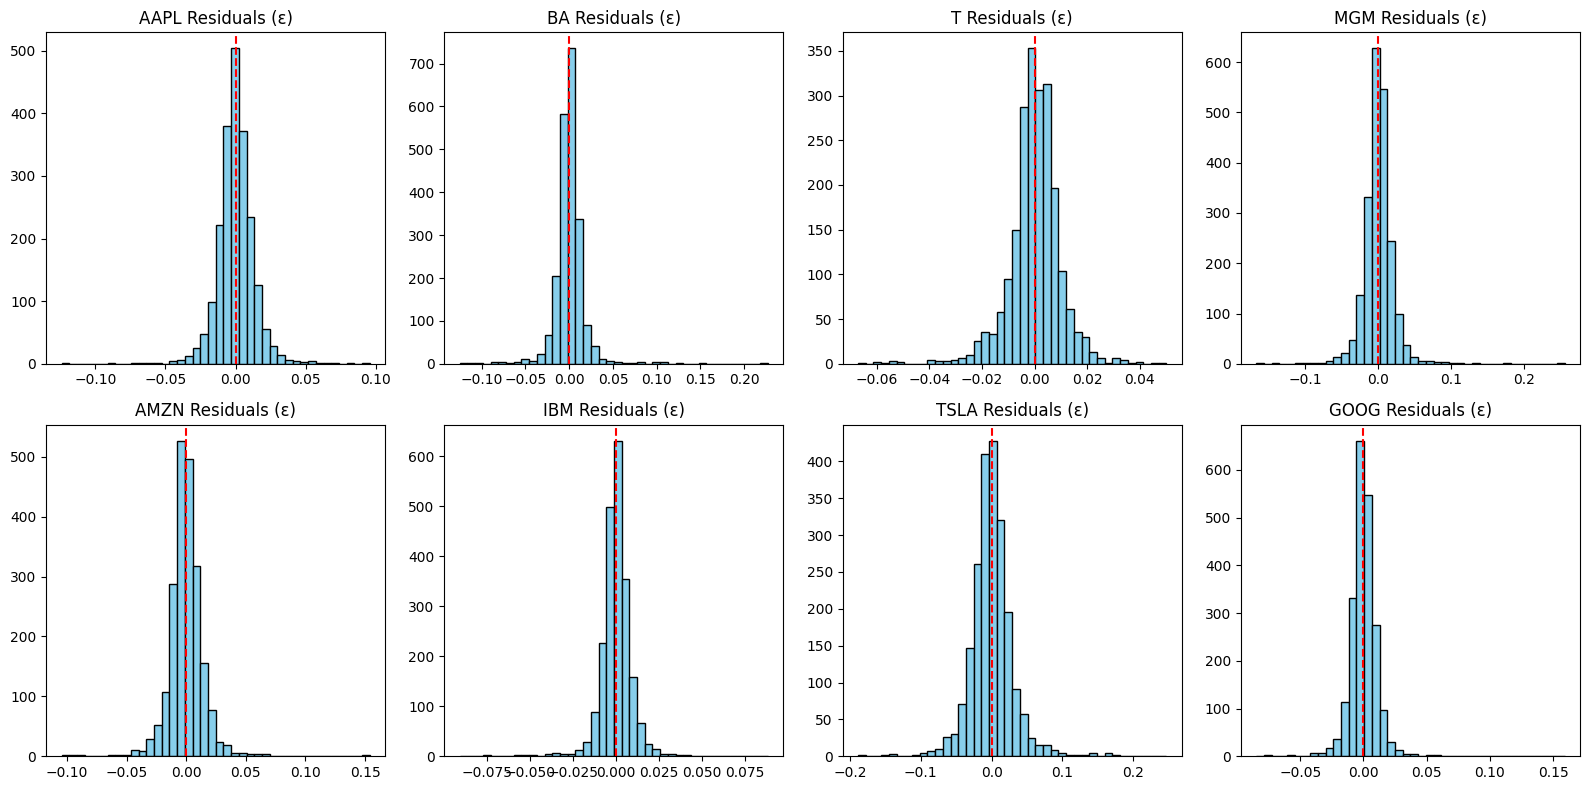

In [ ]:
# Plot histograms of residuals
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, stock in enumerate(residuals_df.columns):
    axes[i].hist(residuals_df[stock], bins=40, color="skyblue", edgecolor="black")
    axes[i].set_title(f"{stock} Residuals (ε)")
    axes[i].axvline(0, color="red", linestyle="--")

plt.tight_layout()
plt.show()

The histograms of the error terms (εᵢ) highlight the part of stock returns not explained by CAPM.

- All residuals are centered around zero, which confirms that the CAPM regressions removed the systematic component of returns. This is consistent with our earlier finding that alphas were close to zero and not statistically significant.
- The width of the distributions varies across stocks, reflecting differences in R². **IBM and AAPL** show narrower residuals, consistent with their higher R² (≈ 0.43–0.50). CAPM explains a relatively large share of their variation. By contrast, **TSLA** has much wider residuals, consistent with its low R² (≈ 0.15). This indicates that most of TSLA’s returns are driven by idiosyncratic, firm-specific factors rather than the market. **MGM and BA** also display relatively wide tails, in line with their high betas but only moderate explanatory power.
- Several stocks (e.g., TSLA, MGM, BA) show fat tails and some skewness, indicating that extreme firm-specific shocks and non-normality remain in the error terms. This illustrates CAPM’s empirical limitation: a single market factor cannot fully capture return dynamics.

**Comment:**  
The residual analysis confirms that while CAPM explains systematic co-movement with the market (through β), a significant portion of stock returns remains idiosyncratic. This matches the lecture’s discussion that CAPM works as a first approximation but fails to capture other risk factors and non-normal return behavior.

### The 4 riskier assets

In [ ]:
# Collect alphas/betas and pick the 4 riskiest assets (highest β)
def summarize_capm_results_v2(results, market_col):
    rows = []
    for stock, model in results.items():
        alpha = model.params['const']
        beta  = model.params[market_col]
        r2    = model.rsquared
        rows.append((stock, alpha, beta, r2))
    return pd.DataFrame(rows, columns=["Stock","Alpha","Beta","R2"])

In [ ]:
summary_df = summarize_capm_results_v2(capm_results, market_col)
summary_df = summary_df.sort_values("Beta", ascending=False).reset_index(drop=True)

top4 = summary_df.head(4).copy()
print("Top 4 by Beta (riskier assets):")
print(top4[["Stock","Beta","Alpha","R2"]])

Top 4 by Beta (riskier assets):
  Stock      Beta     Alpha        R2
0   MGM  1.653568 -0.000169  0.398728
1    BA  1.382867 -0.000023  0.411941
2  TSLA  1.268611  0.001759  0.150482
3  AAPL  1.112891  0.000528  0.432070


In [ ]:
# Form equally-weighted portfolio (25% each)
weights = np.repeat(1/4, 4)

# Portfolio beta/alpha are weight-averages
beta_p  = np.average(top4["Beta"].values,  weights=weights)
alpha_p = np.average(top4["Alpha"].values, weights=weights)

print(f"\nEqually-weighted portfolio parameters:")
print(f"  alpha_p = {alpha_p:.6f}")
print(f"  beta_p  = {beta_p:.4f}")



Equally-weighted portfolio parameters:
  alpha_p = 0.000524
  beta_p  = 1.3545


In [ ]:
# Predicted DAILY portfolio return series from CAPM using observed r_M,t
rM = returns[market_col]
rhat_p = alpha_p + beta_p * rM
rhat_p.name = "rhat_portfolio_CAPM"

# Realized DAILY equal-weight portfolio (to compare)
realized_p = returns[top4["Stock"]].mean(axis=1)
realized_p.name = "realized_portfolio"

# Report sample means (daily and annualized) for the predicted portfolio
muM_daily = rM.mean()
mu_hat_p_daily = alpha_p + beta_p * muM_daily
mu_hat_p_annual = mu_hat_p_daily * 252

print(f"\nEstimated mean return (CAPM-based):")
print(f"  Daily  E[r_p] ≈ {mu_hat_p_daily:.6f}")
print(f"  Annual E[r_p] ≈ {mu_hat_p_annual:.2%}")


Estimated mean return (CAPM-based):
  Daily  E[r_p] ≈ 0.001192
  Annual E[r_p] ≈ 30.04%


The portfolio beta (β ≈ 1.35) confirms that the selected stocks amplify market movements, making the portfolio substantially riskier than the market. The expected annualized return of ~30% matches this higher risk but does not generate abnormal alpha — returns are fully explained by systematic exposure.  

The cumulative returns plot shows that the portfolio outperforms the market in upswings but suffers deeper losses in downturns. This visualizes the tradeoff described by the CAPM: higher beta portfolios deliver higher expected returns at the cost of greater volatility.  

Finally, the Security Market Line (SML) chart places the portfolio above the market, consistent with theory: more systematic risk translates into proportionally higher expected return. The results confirm CAPM’s predictions and highlight the tradeoff between risk and return.


In [ ]:
# Market return (realized, annualized)
muM_annual = muM_daily * 252

# CAPM-predicted portfolio return (annualized)
muP_daily_capm = alpha_p + beta_p * muM_daily
muP_annual_capm = muP_daily_capm * 252

# Realized DAILY equal-weight portfolio (to compare, optional)
realized_p = returns[top4["Stock"]].mean(axis=1)
muP_annual_realized = realized_p.mean() * 252

# Put results into a summary table
results_table = pd.DataFrame({
    "Beta": [1.00, beta_p],
    "Realized Annual Return": [muM_annual, muP_annual_realized],
    "CAPM-Predicted Return": [muM_annual, muP_annual_capm]
}, index=["Market (S&P500)", "High-Beta Portfolio"])

# Display
results_table = results_table.round(4)  # round for readability
print(results_table)

                       Beta  Realized Annual Return  CAPM-Predicted Return
Market (S&P500)      1.0000                  0.1243                 0.1243
High-Beta Portfolio  1.3545                  0.3004                 0.3004


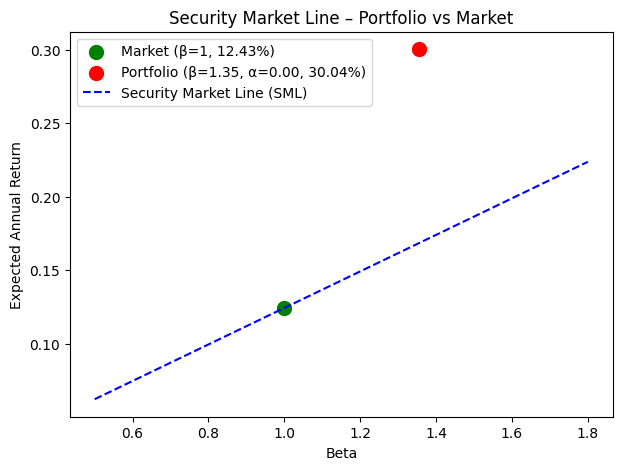

In [ ]:
# Security Market Line plot
avg_rM = rM.mean() * 252
plt.figure(figsize=(7,5))
# Market point
plt.scatter(1, avg_rM, color="green", s=100, label=f"Market (β=1, {avg_rM:.2%})")
# Portfolio point
plt.scatter(beta_p, mu_hat_p_annual, color="red", s=100, label=f"Portfolio (β={beta_p:.2f}, α={alpha_p:.2f}, {mu_hat_p_annual:.2%})")
# Actual point
# plt.scatter(beta_p, muP_annual_realized, color="orange", s=100, label=f"Portfolio actual performance")
# SML line
betas_line = np.linspace(0.5, 1.8, 100)
plt.plot(betas_line, avg_rM * betas_line, color="blue", linestyle="--", label="Security Market Line (SML)")


plt.title("Security Market Line – Portfolio vs Market")
plt.xlabel("Beta")
plt.ylabel("Expected Annual Return")
plt.legend()
plt.show()

**In the graph:**  
- The blue dashed line is the SML: it represents the theoretical relationship between beta and expected return under CAPM.  
- The green dot is the market portfolio (β = 1, annual return ≈ 12.4%). By construction, it lies on the SML.  
- The red dot is the high-beta portfolio (β ≈ 1.35, annual return ≈ 30.0%).  

Under CAPM, the red dot should lie on the SML. Instead, the portfolio sits well above the line, meaning it earns a much higher return than CAPM predicts for β = 1.35.  

This suggests the portfolio has a **positive alpha at the portfolio level** — it delivered higher realized returns than the CAPM benchmark. However, in the regressions earlier, alphas were individually close to zero. The discrepancy arises because:  
- The annualized realized returns in our sample happened to be high, especially due to large moves in stocks like TSLA and MGM.  
- CAPM predicts *expected returns*, while realized returns in finite samples often deviate substantially.  

# Task #3 : Testing the CAPM theory

### 3.1 Compute betas from previous year

In [ ]:
returns.index = pd.to_datetime(returns.index)

# Group returns by year
years = returns.index.year.unique()

results_task3 = []

for y in years[1:]:  # skip first year (no lagged beta)
    # Training sample = year y-1
    train = returns[returns.index.year == y-1]
    test = returns[returns.index.year == y]

    market_train = train[market_col]
    market_test = test[market_col]

    for stock in returns.columns:
        if stock == market_col:
            continue

        # OLS regression: r_i = alpha + beta * r_m
        X = sm.add_constant(market_train)
        y_train = train[stock]
        model = sm.OLS(y_train, X).fit()

        beta = model.params[market_col]

        # Step 2 will add realised and predicted returns
        results_task3.append({
            'Year': y,
            'Stock': stock,
            'Beta_lagged': beta
        })

### 3.2 Compute realized and predicted returns

In [ ]:
# Extend results with realised + predicted annual returns
extended_results = []

for y in years[1:]:
    train = returns[returns.index.year == y-1]
    test = returns[returns.index.year == y]

    market_test = test[market_col]

    for stock in returns.columns:
        if stock == market_col:
            continue

        beta = next(item['Beta_lagged'] for item in results_task3
                    if item['Year'] == y and item['Stock'] == stock)

        realised_return = test[stock].mean() * 252   # annualised
        realised_market = market_test.mean() * 252   # annualised

        predicted_return = beta * realised_market  # rf=0

        extended_results.append({
            'Year': y,
            'Stock': stock,
            'Beta_lagged': beta,
            'Realised_Return': realised_return,
            'Predicted_Return': predicted_return
        })

task3_df = pd.DataFrame(extended_results)
task3_df.head()


,Year,Stock,Beta_lagged,Realised_Return,Predicted_Return
0,2013,AAPL,1.283028,0.094057,0.340683
1,2013,BA,1.024616,0.617045,0.272067
2,2013,T,0.616265,0.054289,0.163637
3,2013,MGM,1.732747,0.746903,0.460098
4,2013,AMZN,1.123074,0.500096,0.298211


### 3.3 Visualisation

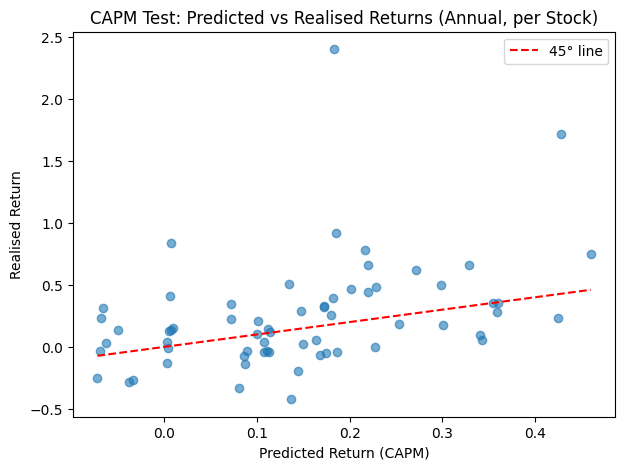

,Year,Stock,Beta_lagged,Realised_Return,Predicted_Return
0,2013,AAPL,1.283028,0.094057,0.340683
1,2013,BA,1.024616,0.617045,0.272067
2,2013,T,0.616265,0.054289,0.163637
3,2013,MGM,1.732747,0.746903,0.460098
4,2013,AMZN,1.123074,0.500096,0.298211


In [ ]:
# Visualisation
plt.figure(figsize=(7,5))
plt.scatter(task3_df['Predicted_Return'], task3_df['Realised_Return'], alpha=0.6)
plt.plot([task3_df['Predicted_Return'].min(), task3_df['Predicted_Return'].max()],
         [task3_df['Predicted_Return'].min(), task3_df['Predicted_Return'].max()],
         color='red', linestyle='--', label='45° line')
plt.xlabel("Predicted Return (CAPM)")
plt.ylabel("Realised Return")
plt.title("CAPM Test: Predicted vs Realised Returns (Annual, per Stock)")
plt.legend()
plt.show()

task3_df.head()

### 3.4 3 year rolling beta instead of 1

In [ ]:
window = 3
results_long_window = []

for y in years[window:]:
    train = returns[(returns.index.year >= y-window) & (returns.index.year < y)]
    test = returns[returns.index.year == y]

    market_train = train[market_col]
    market_test = test[market_col]

    for stock in returns.columns:
        if stock == market_col:
            continue

        X = sm.add_constant(market_train)
        y_train = train[stock]
        model = sm.OLS(y_train, X).fit()

        beta = model.params[market_col]

        realised_return = test[stock].mean() * 252
        realised_market = market_test.mean() * 252
        predicted_return = beta * realised_market

        results_long_window.append({
            'Year': y,
            'Stock': stock,
            'Beta_lagged': beta,
            'Realised_Return': realised_return,
            'Predicted_Return': predicted_return
        })

task3_long_df = pd.DataFrame(results_long_window)
task3_long_df.head()

,Year,Stock,Beta_lagged,Realised_Return,Predicted_Return
0,2015,AAPL,0.942375,-0.011884,0.004408
1,2015,BA,1.010826,0.130017,0.004729
2,2015,T,0.649204,0.036940,0.003037
3,2015,MGM,1.600424,0.135428,0.007487
4,2015,AMZN,1.274606,0.833698,0.005963


### 3.5 Economic Interpretation

In [ ]:
print(f"Number of stocks with overpredicted returns : {task3_df[task3_df['Realised_Return'] < task3_df['Predicted_Return']].shape[0]}")

print(f"Number of stocks with underpredicted returns : {task3_df[task3_df['Realised_Return'] > task3_df['Predicted_Return']].shape[0]}")

print(f"Number of stocks with correctly predicted returns : {task3_df[task3_df['Realised_Return'] == task3_df['Predicted_Return']].shape[0]}")


Number of stocks with overpredicted returns : 29
Number of stocks with underpredicted returns : 35
Number of stocks with correctly predicted returns : 0


In [ ]:
print(f"Mean overprediction % : {abs((task3_df[task3_df['Realised_Return'] < task3_df['Predicted_Return']]['Realised_Return'] - task3_df[task3_df['Realised_Return'] < task3_df['Predicted_Return']]['Predicted_Return']).mean()):.2f}")

print(f"Mean underprediction % : {abs((task3_df[task3_df['Realised_Return'] > task3_df['Predicted_Return']]['Realised_Return'] - task3_df[task3_df['Realised_Return'] > task3_df['Predicted_Return']]['Predicted_Return']).mean()):.2f}")


Mean overprediction % : 0.18
Mean underprediction % : 0.33


Our empirical test shows that CAPM predictions do not line up well with realised returns: the scatter plot is widely dispersed and the 45° line is not a good fit. This matches the lecture’s conclusion that the Security Market Line is “too flat” in practice. High-beta stocks do not consistently earn higher realised returns than low-beta stocks, contradicting the CAPM.

One explanation, as highlighted in class, is that leverage constraints lead investors to overweight high-beta assets, pushing down their future returns, while low-beta stocks become underpriced. This causes the beta–return slope to flatten or even invert. In practice, this means beta alone is not a sufficient measure of expected return, and other risk factors must be considered (consistent with multifactor models like the APT or Fama–French models).

### Optional: Visualisation and Interpretation for different Rolling Window

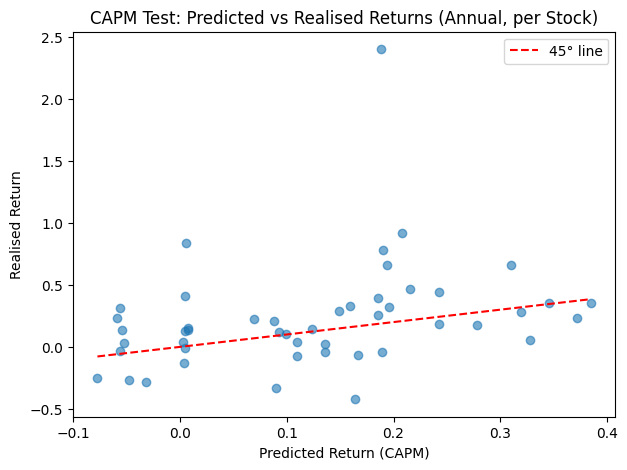

,Year,Stock,Beta_lagged,Realised_Return,Predicted_Return
0,2015,AAPL,0.942375,-0.011884,0.004408
1,2015,BA,1.010826,0.130017,0.004729
2,2015,T,0.649204,0.036940,0.003037
3,2015,MGM,1.600424,0.135428,0.007487
4,2015,AMZN,1.274606,0.833698,0.005963


In [ ]:
# Visualisation
plt.figure(figsize=(7,5))
plt.scatter(task3_long_df['Predicted_Return'], task3_long_df['Realised_Return'], alpha=0.6)
plt.plot([task3_long_df['Predicted_Return'].min(), task3_long_df['Predicted_Return'].max()],
         [task3_long_df['Predicted_Return'].min(), task3_long_df['Predicted_Return'].max()],
         color='red', linestyle='--', label='45° line')
plt.xlabel("Predicted Return (CAPM)")
plt.ylabel("Realised Return")
plt.title("CAPM Test: Predicted vs Realised Returns (Annual, per Stock)")
plt.legend()
plt.show()

task3_long_df.head()

In [ ]:
print(f"Number of stocks with overpredicted returns : {task3_long_df[task3_long_df['Realised_Return'] < task3_long_df['Predicted_Return']].shape[0]}")

print(f"Number of stocks with underpredicted returns : {task3_long_df[task3_long_df['Realised_Return'] > task3_long_df['Predicted_Return']].shape[0]}")

print(f"Number of stocks with correctly predicted returns : {task3_long_df[task3_long_df['Realised_Return'] == task3_long_df['Predicted_Return']].shape[0]}")


Number of stocks with overpredicted returns : 19
Number of stocks with underpredicted returns : 29
Number of stocks with correctly predicted returns : 0


In [ ]:
print(f"Mean overprediction % : {abs((task3_long_df[task3_long_df['Realised_Return'] < task3_long_df['Predicted_Return']]['Realised_Return'] - task3_long_df[task3_long_df['Realised_Return'] < task3_long_df['Predicted_Return']]['Predicted_Return']).mean()):.2f}")

print(f"Mean underprediction % : {abs((task3_long_df[task3_long_df['Realised_Return'] > task3_long_df['Predicted_Return']]['Realised_Return'] - task3_long_df[task3_long_df['Realised_Return'] > task3_long_df['Predicted_Return']]['Predicted_Return']).mean()):.2f}")


Mean overprediction % : 0.18
Mean underprediction % : 0.29


When we estimate betas over a longer 3-year window, the CAPM fit improves only marginally: mean underprediction decreases from 0.33 to 0.29, while mean overprediction remains unchanged at 0.18. This indicates that using a more stable beta reduces some estimation noise, but does not resolve the fundamental issue that realised returns do not align with CAPM predictions. The Security Market Line remains too flat, confirming that beta alone is not sufficient to capture expected returns. This strengthens the case for multifactor models over the simple CAPM.

# Optional Task: Obtain data from web

## Data Gathering and Description

In [ ]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'}

response = requests.get(url, headers = headers)
soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table', {'class': 'wikitable'})

tickers = []
for row in table.find_all('tr')[1:]:
  ticker = row.find_all('td')[0].text.replace('\n','').replace('.','-')
  tickers.append(ticker)


In [ ]:
# Get data from yfinance

data = yf.download(tickers, start='2012-01-1', end='2025-09-22')

/tmp/ipython-input-2814747307.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2012-01-1', end='2025-09-22')
[*********************100%***********************]  503 of 503 completed


In [ ]:
data

Price            Close                                                  \
Ticker               A        AAPL        ABBV        ABNB         ABT   
Date                                                                     
2012-01-03   23.230209   12.345171         NaN         NaN   20.662212   
2012-01-04   23.045536   12.411517         NaN         NaN   20.582060   
2012-01-05   23.561344   12.549312         NaN         NaN   20.534702   
2012-01-06   23.816057   12.680496         NaN         NaN   20.348917   
2012-01-09   24.440119   12.660382         NaN         NaN   20.345274   
...                ...         ...         ...         ...         ...   
2025-09-15  125.629997  236.699997  217.610001  120.370003  131.330002   
2025-09-16  127.190002  238.149994  216.259995  121.660004  132.759995   
2025-09-17  126.720001  238.990005  220.809998  123.199997  134.169998   
2025-09-18  127.620003  237.880005  221.990005  125.470001  134.570007   
2025-09-19  126.320000  245.500000  222.470001  127.040001  136.039993   

Price                                                                 ...  \
Ticker           ACGL         ACN        ADBE         ADI        ADM  ...   
Date                                                                  ...   
2012-01-03  11.879891   41.197598   28.570000   26.420891  19.726862  ...   
2012-01-04  11.664356   41.182049   28.280001   26.384218  20.054615  ...   
2012-01-05  11.886231   40.396221   28.480000   26.501558  19.965849  ...   
2012-01-06  11.873553   40.326199   28.719999   26.325558  19.849770  ...   
2012-01-09  11.787971   40.256172   28.530001   26.838871  19.740513  ...   
...               ...         ...         ...         ...        ...  ...   
2025-09-15  89.860001  237.869995  347.100006  244.910004  60.529999  ...   
2025-09-16  87.379997  236.809998  352.730011  244.100006  62.349998  ...   
2025-09-17  87.349998  241.240005  362.070007  246.320007  61.090000  ...   
2025-09-18  88.190002  239.550003  367.459991  249.050003  60.830002  ...   
2025-09-19  88.400002  239.699997  365.899994  245.330002  61.650002  ...   

Price         Volume                                                   \
Ticker            WY     WYNN       XEL       XOM      XYL        XYZ   
Date                                                                    
2012-01-03   6370900  2032400   3734100  20906800  1059100        NaN   
2012-01-04   6903400  1724100   1919000  16130900  1391900        NaN   
2012-01-05   6117200  2247000   2125100  17452800  2270700        NaN   
2012-01-06   6325900  3059100   1454500  15942100   524400        NaN   
2012-01-09   3428000  1567700   1396800  11664200   558700        NaN   
...              ...      ...       ...       ...      ...        ...   
2025-09-15   3776200  1483200   2756600  12880500  1194100  6474800.0   
2025-09-16   4705000  1416300   3173500  17208000  1109000  5512200.0   
2025-09-17   4855800  1897100   5337600  13302000  1200500  5296900.0   
2025-09-18   3296500  1954200   3050000  14628700  1303600  5443800.0   
2025-09-19  11569300  3328100  10034000  38746500  2435700  7600300.0   

Price                                            
Ticker          YUM      ZBH    ZBRA        ZTS  
Date                                             
2012-01-03  4735660  2016843  120900        NaN  
2012-01-04  5013164  1807650  252500        NaN  
2012-01-05  5059623  2264970  186500        NaN  
2012-01-06  3761264  1692290  194400        NaN  
2012-01-09  3684620  1762948  169400        NaN  
...             ...      ...     ...        ...  
2025-09-15  2605300   957800  486300  3340600.0  
2025-09-16  2370600  1734900  495300  2664900.0  
2025-09-17  2042600  1647900  539100  1958300.0  
2025-09-18  1747400  1304500  479400  2739400.0  
2025-09-19  3068600  4228500  630500  4455800.0  

[3449 rows x 2515 columns]

In [ ]:
data.dropna(axis=1, inplace=True)

In [ ]:
data.head()

Price           Close                                                         \
Ticker              A       AAPL        ABT       ACGL        ACN       ADBE   
Date                                                                           
2012-01-03  23.230209  12.345171  20.662212  11.879891  41.197598  28.570000   
2012-01-04  23.045536  12.411517  20.582060  11.664356  41.182049  28.280001   
2012-01-05  23.561344  12.549312  20.534702  11.886231  40.396221  28.480000   
2012-01-06  23.816057  12.680496  20.348917  11.873553  40.326199  28.719999   
2012-01-09  24.440119  12.660382  20.345274  11.787971  40.256172  28.530001   

Price                                                   ...  Volume          \
Ticker            ADI        ADM        ADP       ADSK  ...     WST     WTW   
Date                                                    ...                   
2012-01-03  26.420891  19.726862  35.021973  30.809999  ...  326600  275348   
2012-01-04  26.384218  20.054615  34.983391  30.209999  ...  319000  268516   
2012-01-05  26.501558  19.965849  35.240612  30.820000  ...  144400  307134   
2012-01-06  26.325558  19.849770  35.292076  30.959999  ...  180200  305473   
2012-01-09  26.838871  19.740513  35.157032  31.080000  ...  241600  458625   

Price                                                                       \
Ticker           WY     WYNN      XEL       XOM      XYL      YUM      ZBH   
Date                                                                         
2012-01-03  6370900  2032400  3734100  20906800  1059100  4735660  2016843   
2012-01-04  6903400  1724100  1919000  16130900  1391900  5013164  1807650   
2012-01-05  6117200  2247000  2125100  17452800  2270700  5059623  2264970   
2012-01-06  6325900  3059100  1454500  15942100   524400  3761264  1692290   
2012-01-09  3428000  1567700  1396800  11664200   558700  3684620  1762948   

Price               
Ticker        ZBRA  
Date                
2012-01-03  120900  
2012-01-04  252500  
2012-01-05  186500  
2012-01-06  194400  
2012-01-09  169400  

[5 rows x 2215 columns]

In [ ]:
data.columns

MultiIndex([( 'Close',    'A'),
            ( 'Close', 'AAPL'),
            ( 'Close',  'ABT'),
            ( 'Close', 'ACGL'),
            ( 'Close',  'ACN'),
            ( 'Close', 'ADBE'),
            ( 'Close',  'ADI'),
            ( 'Close',  'ADM'),
            ( 'Close',  'ADP'),
            ( 'Close', 'ADSK'),
            ...
            ('Volume',  'WST'),
            ('Volume',  'WTW'),
            ('Volume',   'WY'),
            ('Volume', 'WYNN'),
            ('Volume',  'XEL'),
            ('Volume',  'XOM'),
            ('Volume',  'XYL'),
            ('Volume',  'YUM'),
            ('Volume',  'ZBH'),
            ('Volume', 'ZBRA')],
           names=['Price', 'Ticker'], length=2215)

The scraped data contains several other columns not found in the initial provided dataset. Most noteably, columns Open, Close, High, Low, and Volume are present for each stock in the scraped dataset but the provided dataset only includes one price for each stock.

Initially, we thought that the prices in the provided dataset are likely to be the Close prices. However, deeper analysis of this shows that prices do not coincide. Through some research focused on stock split history, we assume that the provided dataset includes Close prices that have/have not been adjusted for some stock splits or dividend payouts.

## Retesting the above tasks on the whole market



### Dataset Preperation

We use the Close prices as the relevant prices and use the sum of individual stock prices as the total market.

In [ ]:
data = data['Close']

In [ ]:
data.rename_axis(None, axis=1)

,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,23.230209,12.345171,20.662212,11.879891,41.197598,28.570000,26.420891,19.726862,35.021973,30.809999,...,17.548344,80.173042,11.515192,83.293503,17.349203,49.966911,20.943560,32.371399,46.723442,35.720001
2012-01-04,23.045536,12.411517,20.582060,11.664356,41.182049,28.280001,26.384218,20.054615,34.983391,30.209999,...,17.382744,79.718460,11.388582,81.861084,17.234978,49.978535,21.635015,32.592464,46.091114,35.450001
2012-01-05,23.561344,12.549312,20.534702,11.886231,40.396221,28.480000,26.501558,19.965849,35.240612,30.820000,...,17.401148,81.102890,11.322265,81.005981,17.311131,49.827461,21.326780,32.841164,46.636810,35.400002
2012-01-06,23.816057,12.680496,20.348917,11.873553,40.326199,28.719999,26.325558,19.849770,35.292076,30.959999,...,17.456341,80.420998,11.466961,78.155739,17.260365,49.455616,20.968546,33.078857,46.758083,35.110001
2012-01-09,24.440119,12.660382,20.345274,11.787971,40.256172,28.530001,26.838871,19.740513,35.157032,31.080000,...,17.493139,79.739151,11.328296,77.936485,17.273052,49.676411,21.051867,32.951714,47.104565,34.950001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-15,125.629997,236.699997,131.330002,89.860001,237.869995,347.100006,244.910004,60.529999,290.869995,321.070007,...,257.529999,333.700012,24.820000,122.849998,73.050003,112.349998,141.740005,148.899994,100.959999,320.910004
2025-09-16,127.190002,238.149994,132.759995,87.379997,236.809998,352.730011,244.100006,62.349998,288.690002,318.510010,...,258.350006,330.720001,24.940001,120.680000,72.110001,114.680000,140.720001,148.009995,99.120003,318.410004
2025-09-17,126.720001,238.990005,134.169998,87.349998,241.240005,362.070007,246.320007,61.090000,288.750000,319.279999,...,256.640015,332.329987,24.490000,123.279999,72.050003,115.290001,140.990005,148.259995,99.919998,317.320007


In [ ]:
data['market'] = data.sum(axis=1)
data

/tmp/ipython-input-597395055.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['market'] = data.sum(axis=1)
/tmp/ipython-input-597395055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['market'] = data.sum(axis=1)


Ticker,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,market
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,23.230209,12.345171,20.662212,11.879891,41.197598,28.570000,26.420891,19.726862,35.021973,30.809999,...,80.173042,11.515192,83.293503,17.349203,49.966911,20.943560,32.371399,46.723442,35.720001,14329.297702
2012-01-04,23.045536,12.411517,20.582060,11.664356,41.182049,28.280001,26.384218,20.054615,34.983391,30.209999,...,79.718460,11.388582,81.861084,17.234978,49.978535,21.635015,32.592464,46.091114,35.450001,14309.967726
2012-01-05,23.561344,12.549312,20.534702,11.886231,40.396221,28.480000,26.501558,19.965849,35.240612,30.820000,...,81.102890,11.322265,81.005981,17.311131,49.827461,21.326780,32.841164,46.636810,35.400002,14396.916647
2012-01-06,23.816057,12.680496,20.348917,11.873553,40.326199,28.719999,26.325558,19.849770,35.292076,30.959999,...,80.420998,11.466961,78.155739,17.260365,49.455616,20.968546,33.078857,46.758083,35.110001,14383.450530
2012-01-09,24.440119,12.660382,20.345274,11.787971,40.256172,28.530001,26.838871,19.740513,35.157032,31.080000,...,79.739151,11.328296,77.936485,17.273052,49.676411,21.051867,32.951714,47.104565,34.950001,14423.084884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-15,125.629997,236.699997,131.330002,89.860001,237.869995,347.100006,244.910004,60.529999,290.869995,321.070007,...,333.700012,24.820000,122.849998,73.050003,112.349998,141.740005,148.899994,100.959999,320.910004,106192.799413
2025-09-16,127.190002,238.149994,132.759995,87.379997,236.809998,352.730011,244.100006,62.349998,288.690002,318.510010,...,330.720001,24.940001,120.680000,72.110001,114.680000,140.720001,148.009995,99.120003,318.410004,105843.681585
2025-09-17,126.720001,238.990005,134.169998,87.349998,241.240005,362.070007,246.320007,61.090000,288.750000,319.279999,...,332.329987,24.490000,123.279999,72.050003,115.290001,140.990005,148.259995,99.919998,317.320007,105950.550214


In [ ]:
returns = compute_returns(data)

In [ ]:
# Extract market returns
market_col = 'market'
market_returns = returns[market_col]

### Running OLS Regression

In [ ]:
capm_results = run_capm_regression(returns, market_col="market", show=False)

In [ ]:
summary_df = summarize_capm_results(capm_results)
display(summary_df)

,Stock,Alpha,Beta,R²,p(Alpha),p(Beta)
0,A,-0.000072,1.105669,0.486592,0.724078,0.000000e+00
1,AAPL,0.000363,1.047076,0.376727,0.134234,0.000000e+00
2,ABT,0.000125,0.817007,0.378828,0.506430,0.000000e+00
3,ACGL,0.000133,0.891431,0.375527,0.519120,0.000000e+00
4,ACN,-0.000042,1.049847,0.533364,0.811698,0.000000e+00
...,...,...,...,...,...,...
438,XOM,-0.000164,0.830435,0.300265,0.471655,1.638045e-269
439,XYL,-0.000018,1.118863,0.510304,0.925800,0.000000e+00
440,YUM,0.000007,0.849483,0.360891,0.972467,0.000000e+00
441,ZBH,-0.000228,0.910856,0.353443,0.304095,0.000000e+00


In [ ]:
# Round for readability
summary_df_round = summary_df.round(4)

# Sort for top 10 by Beta
betas_sorted = summary_df_round.sort_values("Beta", ascending=False)[:10]
display(betas_sorted.style.background_gradient(subset=["Beta"], cmap="Reds").set_caption("Stocks Sorted by Beta"))

# Sort for top 10 by Alpha
alphas_sorted = summary_df_round.sort_values("Alpha", ascending=False)[:10]
display(alphas_sorted.style.background_gradient(subset=["Alpha"], cmap="Greens").set_caption("Stocks Sorted by Alpha"))

,Stock,Alpha,Beta,R²,p(Alpha),p(Beta)
57,BLDR,0.000600,1.740300,0.313000,0.196900,0.000000
308,ON,-0.000100,1.716300,0.390000,0.748100,0.000000
410,URI,0.000300,1.703100,0.451100,0.385500,0.000000
339,RCL,0.000200,1.652900,0.339100,0.652300,0.000000
74,CCL,-0.000500,1.650900,0.308200,0.262100,0.000000
267,MGM,-0.000300,1.643500,0.415900,0.352100,0.000000
278,MPWR,0.000600,1.621500,0.410400,0.110900,0.000000
160,FCX,-0.000400,1.612600,0.291800,0.358900,0.000000
250,LRCX,0.000400,1.561000,0.445600,0.220000,0.000000
22,AMD,0.000600,1.560300,0.214200,0.262100,0.000000


,Stock,Alpha,Beta,R²,p(Alpha),p(Beta)
396,TSLA,0.001300,1.457100,0.178100,0.020400,0.000000
301,NVDA,0.001300,1.514600,0.317000,0.001600,0.000000
41,AXON,0.001200,1.199000,0.167800,0.016600,0.000000
292,NFLX,0.001100,1.065700,0.142800,0.014600,0.000000
389,TPL,0.001000,1.008700,0.157800,0.021400,0.000000
359,SMCI,0.000900,1.324900,0.125600,0.147300,0.000000
38,AVGO,0.000900,1.329800,0.354400,0.004700,0.000000
386,TKO,0.000800,0.828800,0.121600,0.053600,0.000000
371,SW,0.000700,0.423800,0.029900,0.094500,0.000000
130,DXCM,0.000700,1.119000,0.158600,0.128100,0.000000


In [ ]:
# Sort for bottom 10 by Beta
betas_sorted = summary_df_round.sort_values("Beta", ascending=True)[:10]
display(betas_sorted.style.background_gradient(subset=["Beta"], cmap="Reds").set_caption("Stocks Sorted by Beta"))

# Sort for bottom 10 by Alpha
alphas_sorted = summary_df_round.sort_values("Alpha", ascending=True)[:10]
display(alphas_sorted.style.background_gradient(subset=["Alpha"], cmap="Greens").set_caption("Stocks Sorted by Alpha"))

,Stock,Alpha,Beta,R²,p(Alpha),p(Beta)
227,K,0.000100,0.364700,0.095400,0.559500,0.000000
97,CPB,-0.000000,0.365700,0.071800,0.985600,0.000000
237,KR,0.000500,0.369500,0.054600,0.091900,0.000000
83,CLX,0.000100,0.371700,0.085200,0.521700,0.000000
176,GIS,0.000000,0.396700,0.113400,0.903000,0.000000
357,SJM,0.000000,0.416900,0.098200,0.843300,0.000000
371,SW,0.000700,0.423800,0.029900,0.094500,0.000000
134,ED,0.000100,0.434200,0.140300,0.666700,0.000000
291,NEM,0.000200,0.436700,0.041100,0.687300,0.000000
198,HRL,0.000100,0.442200,0.119300,0.809500,0.000000


,Stock,Alpha,Beta,R²,p(Alpha),p(Beta)
30,APA,-0.000700,1.470000,0.220700,0.164900,0.000000
372,SWK,-0.000600,1.395300,0.513600,0.024200,0.000000
358,SLB,-0.000600,1.144500,0.277700,0.087000,0.000000
188,HAL,-0.000600,1.355300,0.290200,0.146500,0.000000
50,BEN,-0.000500,1.251700,0.479900,0.019400,0.000000
311,OXY,-0.000500,1.201300,0.218700,0.256700,0.000000
276,MOS,-0.000500,1.165100,0.230200,0.229700,0.000000
419,VTRS,-0.000500,0.945000,0.200500,0.119900,0.000000
219,IVZ,-0.000500,1.548500,0.528400,0.038800,0.000000
129,DVN,-0.000500,1.370000,0.241600,0.247400,0.000000


In [ ]:
print(f"Number of Stocks with Beta > 1 : {summary_df[summary_df['Beta'] > 1].shape[0]}")

print(f"Number of Stocks with Beta < 1 : {summary_df[summary_df['Beta'] < 1].shape[0]}")

print(f"Number of Stocks with Beta = 1 : {summary_df[summary_df['Beta'] == 1].shape[0]}")

Number of Stocks with Beta > 1 : 234
Number of Stocks with Beta < 1 : 209
Number of Stocks with Beta = 1 : 0


In [ ]:
print(f"Average Beta : {summary_df['Beta'].mean()}")

Average Beta : 1.0038772607180082


The OLS results deliver similar performance to the original dataset. We have a similar ratio of Betas > 1 and < 1, with a similar mean.

Moreover, an interesting observation with regards to the average Beta. In this case, we observe a smaller Beta and one that is much closer to 1. This behaviour is expected given that the original dataset consisted mainly of high growth tech stocks, whereas the scraped dataset contains a more balanced set of stocks. We can see this from the table above that lists the lowest 10 estimated Betas, all being significantly lower than the ~0.7 Beta of AT&T from the original dataset.

In [ ]:
# Compute Residuals & Choose 8 Random Tickers
residuals_df = compute_residuals(capm_results, returns, market_col="market")
residuals_df = residuals_df.sample(n=8, axis=1)

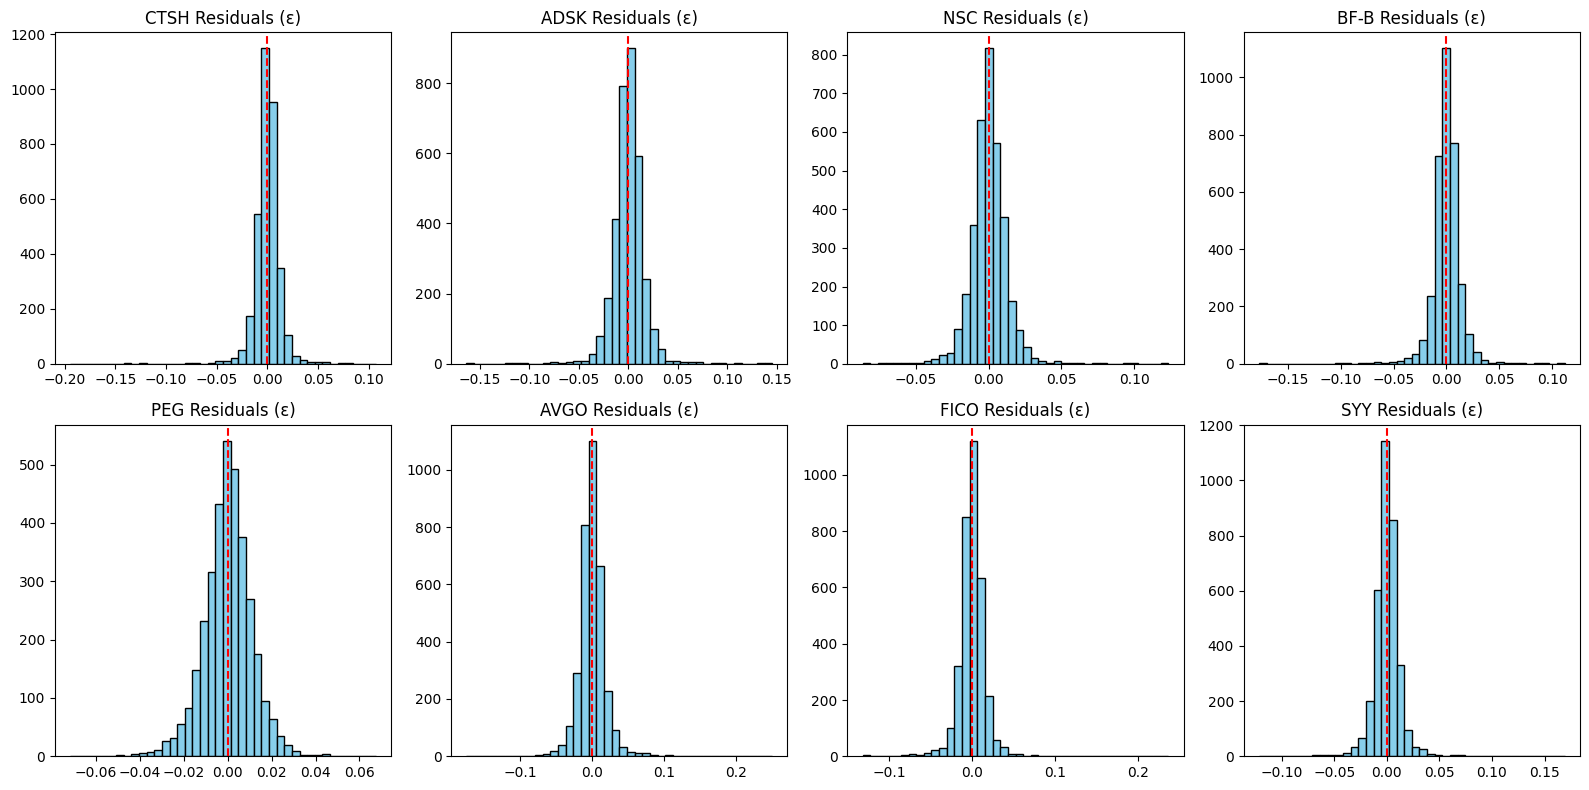

In [ ]:
# Plot histograms of residuals
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, stock in enumerate(residuals_df.columns):
    axes[i].hist(residuals_df[stock], bins=40, color="skyblue", edgecolor="black")
    axes[i].set_title(f"{stock} Residuals (ε)")
    axes[i].axvline(0, color="red", linestyle="--")

plt.tight_layout()
plt.show()

Taking a random set of 8 stocks for ease of visualisation, we observe similar results to the original exploration : a significant portion of stock returns remains idiosyncratic. This matches the lecture’s discussion that CAPM works as a first approximation but fails to capture other risk factors and non-normal return behavior.

### The 4 riskier assets

In [ ]:
summary_df = summarize_capm_results_v2(capm_results, market_col)
summary_df = summary_df.sort_values("Beta", ascending=False).reset_index(drop=True)

top4 = summary_df.head(4).copy()
print("Top 4 by Beta (riskier assets):")
print(top4[["Stock","Beta","Alpha","R2"]])

Top 4 by Beta (riskier assets):
  Stock      Beta     Alpha        R2
0  BLDR  1.740251  0.000599  0.313002
1    ON  1.716318 -0.000124  0.390016
2   URI  1.703061  0.000294  0.451051
3   RCL  1.652943  0.000187  0.339086


In [ ]:
# Form equally-weighted portfolio (25% each)
weights = np.repeat(1/4, 4)

# Portfolio beta/alpha are weight-averages
beta_p  = np.average(top4["Beta"].values,  weights=weights)
alpha_p = np.average(top4["Alpha"].values, weights=weights)

print(f"\nEqually-weighted portfolio parameters:")
print(f"  alpha_p = {alpha_p:.6f}")
print(f"  beta_p  = {beta_p:.4f}")



Equally-weighted portfolio parameters:
  alpha_p = 0.000239
  beta_p  = 1.7031


In [ ]:
# Predicted DAILY portfolio return series from CAPM using observed r_M,t
rM = returns[market_col]
rhat_p = alpha_p + beta_p * rM
rhat_p.name = "rhat_portfolio_CAPM"

# Realized DAILY equal-weight portfolio (to compare)
realized_p = returns[top4["Stock"]].mean(axis=1)
realized_p.name = "realized_portfolio"

# Report sample means (daily and annualized) for the predicted portfolio
muM_daily = rM.mean()
mu_hat_p_daily = alpha_p + beta_p * muM_daily
mu_hat_p_annual = mu_hat_p_daily * 252

print(f"\nEstimated mean return (CAPM-based):")
print(f"  Daily  E[r_p] ≈ {mu_hat_p_daily:.6f}")
print(f"  Annual E[r_p] ≈ {mu_hat_p_annual:.2%}")


Estimated mean return (CAPM-based):
  Daily  E[r_p] ≈ 0.001323
  Annual E[r_p] ≈ 33.33%


In [ ]:
# Market return (realized, annualized)
muM_annual = muM_daily * 252

# CAPM-predicted portfolio return (annualized)
muP_daily_capm = alpha_p + beta_p * muM_daily
muP_annual_capm = muP_daily_capm * 252

# Realized DAILY equal-weight portfolio (to compare, optional)
realized_p = returns[top4["Stock"]].mean(axis=1)
muP_annual_realized = realized_p.mean() * 252

# Put results into a summary table
results_table = pd.DataFrame({
    "Beta": [1.00, beta_p],
    "Realized Annual Return": [muM_annual, muP_annual_realized],
    "CAPM-Predicted Return": [muM_annual, muP_annual_capm]
}, index=["Market (S&P500)", "High-Beta Portfolio"])

# Display
results_table = results_table.round(4)  # round for readability
print(results_table)

                       Beta  Realized Annual Return  CAPM-Predicted Return
Market (S&P500)      1.0000                  0.1603                 0.1603
High-Beta Portfolio  1.7031                  0.3333                 0.3333


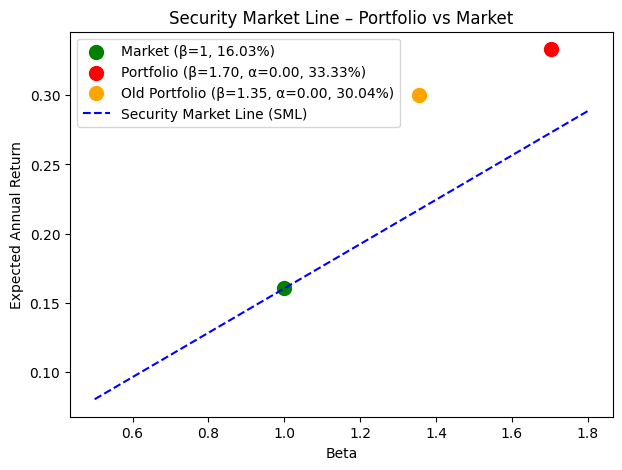

In [ ]:
# Security Market Line plot
avg_rM = rM.mean() * 252
plt.figure(figsize=(7,5))
# Market point
plt.scatter(1, avg_rM, color="green", s=100, label=f"Market (β=1, {avg_rM:.2%})")
# Portfolio point
plt.scatter(beta_p, mu_hat_p_annual, color="red", s=100, label=f"Portfolio (β={beta_p:.2f}, α={alpha_p:.2f}, {mu_hat_p_annual:.2%})")
# Portfolio point
plt.scatter(1.3545, 0.3004, color="orange", s=100, label=f"Old Portfolio (β=1.35, α=0.00, 30.04%)")
# Actual point
# plt.scatter(beta_p, muP_annual_realized, color="orange", s=100, label=f"Portfolio actual performance")
# SML line
betas_line = np.linspace(0.5, 1.8, 100)
plt.plot(betas_line, avg_rM * betas_line, color="blue", linestyle="--", label="Security Market Line (SML)")


plt.title("Security Market Line – Portfolio vs Market")
plt.xlabel("Beta")
plt.ylabel("Expected Annual Return")
plt.legend()
plt.show()

Once again, we see that the portfolio outperforms the CAPM expectations represented by the SML. We see that it outperforms the old portfolio, however, this is hardly surprising given the siginficantly higher Beta of this portfolio. Once again, we suspect the finiteness of the sample to be the reason to be a source of this discrepency. Given CAPM is a single facotr model, the model may be failing to capture other sources of variability in stock returns. This result is highlighted in the results of both datasets.  

### Testing the CAPM Theory

In [ ]:
# We ensure index is datetime
returns.index = pd.to_datetime(returns.index)

# Group returns by year
years = returns.index.year.unique()

results_task3 = []

for y in years[1:]:  # we skip first year (there's no lagged beta available)
    # Estimate betas using year y-1
    train = returns[returns.index.year == y-1]
    test = returns[returns.index.year == y]

    market_train = train[market_col]
    market_test = test[market_col]

    for stock in returns.columns:
        if stock == market_col:
            continue

        # Run OLS regression: r_i = alpha + beta * r_m
        X = sm.add_constant(market_train)
        y_train = train[stock]
        model = sm.OLS(y_train, X).fit()

        beta = model.params[market_col]

        # Compute realised avg returns (year y)
        realised_return = test[stock].mean() * 252   # annualised
        realised_market = market_test.mean() * 252   # annualised

        # CAPM predicted return
        predicted_return = beta * realised_market  # rf = 0

        results_task3.append({
            'Year': y,
            'Stock': stock,
            'Beta_lagged': beta,
            'Realised_Return': realised_return,
            'Predicted_Return': predicted_return
        })

# Convert results to DataFrame
task3_df = pd.DataFrame(results_task3)

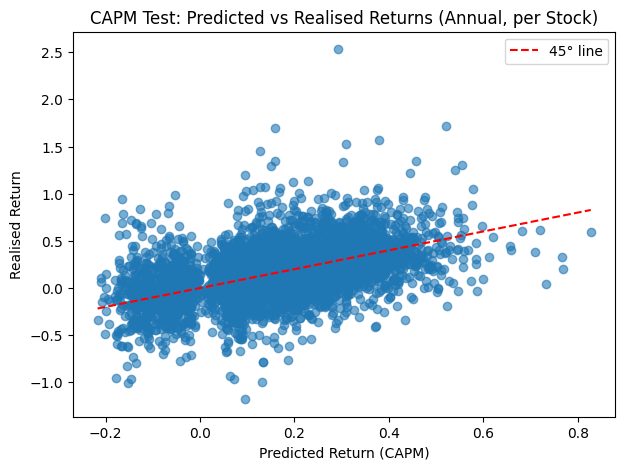

,Year,Stock,Beta_lagged,Realised_Return,Predicted_Return
0,2013,A,1.568076,0.368865,0.493698
1,2013,AAPL,1.099333,0.118876,0.346118
2,2013,ABT,0.526866,0.233705,0.165880
3,2013,ACGL,0.451871,0.313867,0.142269
4,2013,ACN,1.142265,0.257252,0.359634


In [ ]:
# Visualisation
plt.figure(figsize=(7,5))
plt.scatter(task3_df['Predicted_Return'], task3_df['Realised_Return'], alpha=0.6)
plt.plot([task3_df['Predicted_Return'].min(), task3_df['Predicted_Return'].max()],
         [task3_df['Predicted_Return'].min(), task3_df['Predicted_Return'].max()],
         color='red', linestyle='--', label='45° line')
plt.xlabel("Predicted Return (CAPM)")
plt.ylabel("Realised Return")
plt.title("CAPM Test: Predicted vs Realised Returns (Annual, per Stock)")
plt.legend()
plt.show()

task3_df.head()

This scatter plot compares predicted returns from the CAPM with actual realized returns at the stock-year level. If the CAPM were accurate, the points would cluster tightly around the 45° line (shown in red), indicating that predicted and realized returns align quite well. Instead, the points are widely dispersed, with substantial deviations above and below the line, and only a weak positive association between predicted and realized values. This pattern shows that while CAPM predictions move somewhat in the right direction, higher predicted returns tend to be associated with higher realized returns, the model explains only a small fraction of the variation in outcomes. In short, the figure highlights the limited explanatory power of the CAPM in practice, with realized returns influenced by many factors beyond market beta, a classic argument against the one factor model of CAPM.

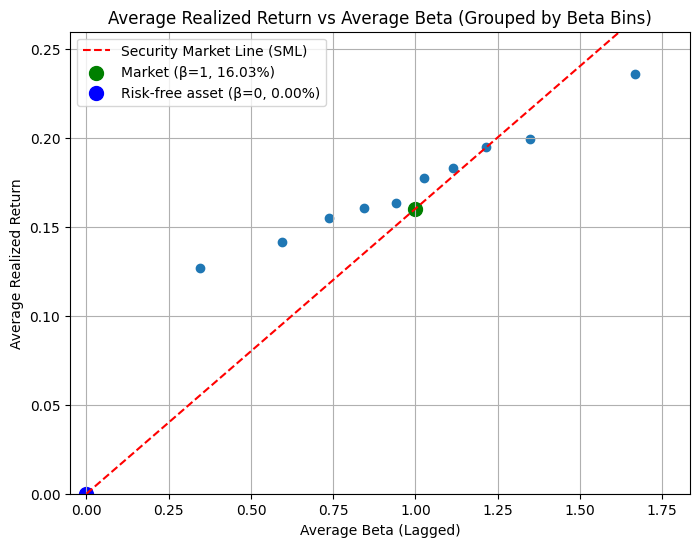

In [ ]:
# Calculate average realized return for each stock across all years
avg_realized_returns = task3_df.groupby('Stock')['Realised_Return'].mean()

# Merge average realized returns with lagged betas
merged_df = pd.merge(task3_df[['Stock', 'Beta_lagged']].drop_duplicates(), avg_realized_returns, on='Stock')

# Group betas into 10 bins and calculate average beta and average realized return for each bin
try:
    beta_bins_summary = merged_df.groupby(pd.qcut(merged_df['Beta_lagged'], q=10, labels=False, duplicates='drop')).agg(
        Avg_Beta=('Beta_lagged', 'mean'),
        Avg_Realized_Return=(avg_realized_returns.name, 'mean')  # Use the series name
    ).reset_index()
except ValueError:
    # If qcut fails due to duplicates, use fewer bins
    beta_bins_summary = merged_df.groupby(pd.qcut(merged_df['Beta_lagged'], q=5, labels=False, duplicates='drop')).agg(
        Avg_Beta=('Beta_lagged', 'mean'),
        Avg_Realized_Return=(avg_realized_returns.name, 'mean')
    ).reset_index()


# Calculate average realized return for each stock across all years
avg_realized_returns = task3_df.groupby('Stock')['Realised_Return'].mean()

# Merge average realized returns with lagged betas
merged_df = pd.merge(task3_df[['Stock', 'Beta_lagged']].drop_duplicates(), avg_realized_returns, on='Stock')

# Group betas into 10 bins and calculate average beta and average realized return for each bin
try:
    beta_bins_summary = merged_df.groupby(pd.qcut(merged_df['Beta_lagged'], q=10, labels=False, duplicates='drop')).agg(
        Avg_Beta=('Beta_lagged', 'mean'),
        Avg_Realized_Return=(avg_realized_returns.name, 'mean')  # Use the series name
    ).reset_index()
except ValueError:
    # If qcut fails due to duplicates, use fewer bins
    beta_bins_summary = merged_df.groupby(pd.qcut(merged_df['Beta_lagged'], q=5, labels=False, duplicates='drop')).agg(
        Avg_Beta=('Beta_lagged', 'mean'),
        Avg_Realized_Return=(avg_realized_returns.name, 'mean')
    ).reset_index()

# Plot average beta vs average realized returns for each bin
plt.figure(figsize=(8, 6))
plt.scatter(beta_bins_summary['Avg_Beta'], beta_bins_summary['Avg_Realized_Return'])
plt.xlabel('Average Beta (Lagged)')
plt.ylabel('Average Realized Return')
plt.title('Average Realized Return vs Average Beta (Grouped by Beta Bins)')

# Calculate the overall average market return from the returns DataFrame directly
overall_avg_market_return = returns[market_col].mean() * 252  # Annualize the daily mean

# Assuming risk-free rate = 0
risk_free_rate = 0
market_risk_premium = overall_avg_market_return - risk_free_rate

# Plot SML: E(R) = Rf + β × (E(Rm) - Rf)
# Extend the line to start from beta = 0 to show the y-intercept clearly
betas_line = np.linspace(0, beta_bins_summary['Avg_Beta'].max() * 1.1, 100)
sml_returns = risk_free_rate + betas_line * market_risk_premium
plt.plot(betas_line, sml_returns, color="red", linestyle="--", label="Security Market Line (SML)")

# Add the market point (should lie exactly on SML by construction)
plt.scatter(1, overall_avg_market_return, color="green", s=100, label=f"Market (β=1, {overall_avg_market_return:.2%})")

# Add risk-free asset point to explicitly show the y-intercept
plt.scatter(0, risk_free_rate, color="blue", s=100, label=f"Risk-free asset (β=0, {risk_free_rate:.2%})")

# Set axis limits to clearly show the y-intercept
plt.xlim(-0.05, beta_bins_summary['Avg_Beta'].max() * 1.1)  # Start slightly below 0 to show y-intercept
plt.ylim(min(risk_free_rate, beta_bins_summary['Avg_Realized_Return'].min()) * 1.1,
         beta_bins_summary['Avg_Realized_Return'].max() * 1.1)

plt.legend()
plt.grid(True)
plt.show()

The plot of the binned betas compares average realized returns by beta bins with the theoretical SML implied by the CAPM. While the red dashed line represents the expected linear relationship between beta and return, the bin averages lie consistently above it, indicating that stocks across the beta spectrum earned higher realized returns than the CAPM would predict. The market point (green) falls on the theoretical SML by construction, but the empirical pattern suggests a steeper slope and upward shift relative to the CAPM line. This misalignment highlights a common empirical finding: the CAPM does not hold well in practice, as realized returns are not fully explained by beta alone. This indicates that CAPM does not fully capture the factors that impact stock movement.


In [ ]:
print(f"Number of stocks with overpredicted returns : {task3_df [task3_df['Realised_Return'] < task3_df['Predicted_Return']].shape[0]}")

print(f"Number of stocks with underpredicted returns : {task3_df[task3_df['Realised_Return'] > task3_df['Predicted_Return']].shape[0]}")

print(f"Number of stocks with correctly predicted returns : {task3_df[task3_df['Realised_Return'] == task3_df['Predicted_Return']].shape[0]}")


Number of stocks with overpredicted returns : 2673
Number of stocks with underpredicted returns : 3086
Number of stocks with correctly predicted returns : 0


In [ ]:
print(f"Mean overprediction % : {abs((task3_df[task3_df['Realised_Return'] < task3_df['Predicted_Return']]['Realised_Return'] - task3_df[task3_df['Realised_Return'] < task3_df['Predicted_Return']]['Predicted_Return']).mean()):.2f}")

print(f"Mean underprediction % : {abs((task3_df[task3_df['Realised_Return'] > task3_df['Predicted_Return']]['Realised_Return'] - task3_df[task3_df['Realised_Return'] > task3_df['Predicted_Return']]['Predicted_Return']).mean()):.2f}")


Mean overprediction % : 0.17
Mean underprediction % : 0.18


Moreover, we see that on average, the predicted CAPM returns evenly overpredict and underpredict returns, unlike in the first dataset. However, a mean average incorrect prediction of 17% remains quite high further highlighting the models ability to predict stock returns.

Thus, by including all the stocks from the S&P 500 we managed to lower our underprediction error, while keeping the overprediction score steady. We believe that this decrease in error could be due to the larger sample size.